In [1]:
import torch
import gpytorch
import online_gp

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

import time

In [2]:
from online_gp.models.batched_fixed_noise_online_gp import FixedNoiseOnlineSKIGP
from online_gp.mlls.batched_woodbury_marginal_log_likelihood import BatchedWoodburyMarginalLogLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

In [3]:
def make_plot(pred_dist, i):
    pred_classes = pred_dist.mean.argmax(dim=0)
    exp_samples = pred_dist.rsample(torch.Size((100,))).exp()
    pred_class1 = (exp_samples / exp_samples.sum(dim=1,keepdim=True)).mean(dim=0)[0].detach()

    fig, ax = plt.subplots(1, 2, figsize = (8, 3))
    ax[0].contourf(pred_x[:,0].reshape(50,50), 
                pred_x[:,1].reshape(50,50), 
                pred_classes.detach().view(-1).reshape(50,50), colors=['lightblue', 'pink'], levels=1)

    ax[0].scatter(*train_x[:i].t(), c=train_y[:i] + 1)
    ax[0].set_title('N='+str(i))

    f = ax[1].contourf(pred_x[:,0].reshape(50,50), 
                pred_x[:,1].reshape(50,50), pred_class1.reshape(50,50), levels = 10)
    fig.colorbar(f, ax=ax[1])
    ax[1].set_title('P(Class = 1)')
    plt.show()

Let's download and prepare the bananas dataset from Thang Bui's OSVGP repo.

In [4]:
train_x = pd.read_csv("https://raw.githubusercontent.com/thangbui/streaming_sparse_gp/master/data/banana_train_x.txt",
                     header=None)
train_y = pd.read_csv("https://raw.githubusercontent.com/thangbui/streaming_sparse_gp/master/data/banana_train_y.txt",
                     header=None)

train_x = torch.tensor(train_x.values).float()

train_y = torch.tensor(train_y.values)#.float()
train_y[train_y < 0] = 0.
train_y = train_y.view(-1)
alpha_epsilon = 0.01

alpha = alpha_epsilon * torch.ones(train_x.shape[0], 2)
alpha[torch.arange(len(train_y)), train_y] = alpha[torch.arange(len(train_y)), train_y] + 1.

sigma2_i = torch.log(1./ alpha + 1.)

transformed_targets = alpha.log() - 0.5 * sigma2_i

In [5]:
init_x = train_x[:5]
init_y = transformed_targets[:5]#.t()
init_yvar = sigma2_i[:5]#.t()

In [6]:
init_yvar.shape

torch.Size([5, 2])

We will train through the entire dataset starting at five data points.

In [7]:
model = FixedNoiseOnlineSKIGP(init_x, init_y, init_yvar, 
                      grid_bounds = torch.tensor([[-3.2, 3.2], [-3.2, 3.2]]), learn_additional_noise=False)


In [8]:
mll = BatchedWoodburyMarginalLogLikelihood(model.likelihood, model)
# mll = ExactMarginalLogLikelihood(model.likelihood, model)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [9]:
grid_vals = np.meshgrid(np.linspace(-2.5, 2.5), np.linspace(-2.5, 2.5))

pred_x = torch.tensor((grid_vals[0].reshape(-1), grid_vals[1].reshape(-1))).float().t()

In [10]:
%pdb

Automatic pdb calling has been turned ON


Outputscale:  Parameter containing:
tensor([0.0129, 0.0200], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[0.0208]],

        [[0.0141]]], requires_grad=True)
Step:  25 Train Loss:  tensor(5.9241, grad_fn=<NegBackward>)


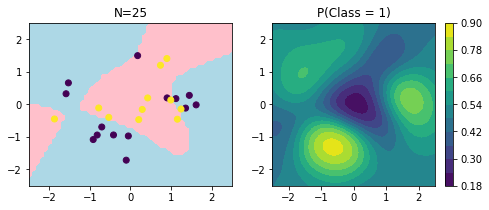

Outputscale:  Parameter containing:
tensor([0.0383, 0.0445], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[0.0411]],

        [[0.0378]]], requires_grad=True)
Step:  50 Train Loss:  tensor(5.7178, grad_fn=<NegBackward>)


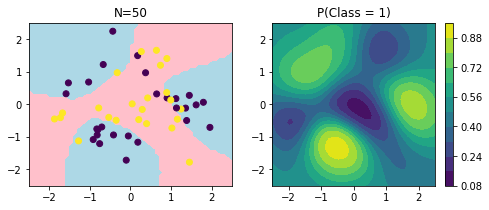

Outputscale:  Parameter containing:
tensor([0.0661, 0.0697], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[0.0446]],

        [[0.0391]]], requires_grad=True)
Step:  75 Train Loss:  tensor(5.3990, grad_fn=<NegBackward>)


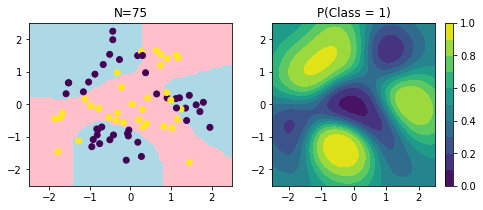

Outputscale:  Parameter containing:
tensor([0.0960, 0.0976], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[0.0277]],

        [[0.0150]]], requires_grad=True)
Step:  100 Train Loss:  tensor(5.1579, grad_fn=<NegBackward>)


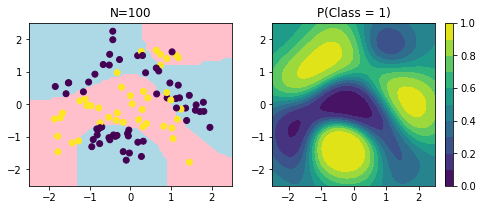

Outputscale:  Parameter containing:
tensor([0.1258, 0.1254], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[ 0.0027]],

        [[-0.0195]]], requires_grad=True)
Step:  125 Train Loss:  tensor(4.9839, grad_fn=<NegBackward>)


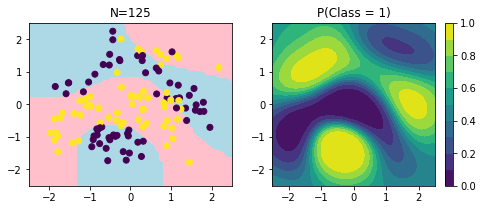

Outputscale:  Parameter containing:
tensor([0.1596, 0.1492], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[-0.0277]],

        [[-0.0468]]], requires_grad=True)
Step:  150 Train Loss:  tensor(4.8218, grad_fn=<NegBackward>)


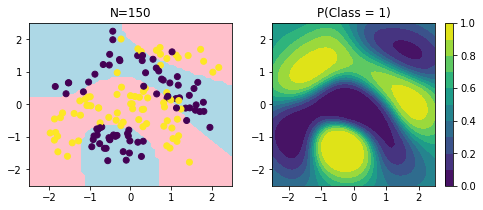

Outputscale:  Parameter containing:
tensor([0.1929, 0.1712], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[-0.0599]],

        [[-0.0708]]], requires_grad=True)
Step:  175 Train Loss:  tensor(4.7035, grad_fn=<NegBackward>)


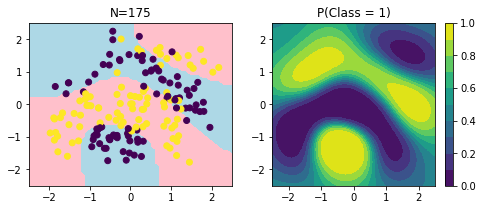

Outputscale:  Parameter containing:
tensor([0.2239, 0.1932], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[-0.0904]],

        [[-0.0958]]], requires_grad=True)
Step:  200 Train Loss:  tensor(4.5950, grad_fn=<NegBackward>)


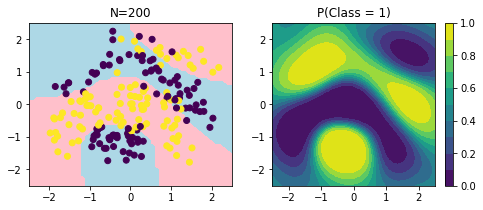

Outputscale:  Parameter containing:
tensor([0.2521, 0.2150], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[-0.1156]],

        [[-0.1199]]], requires_grad=True)
Step:  225 Train Loss:  tensor(4.5063, grad_fn=<NegBackward>)


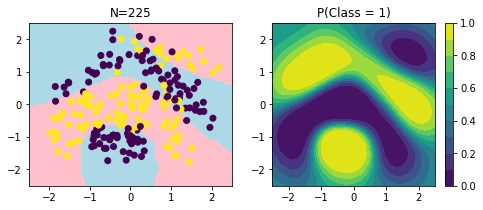

Outputscale:  Parameter containing:
tensor([0.2783, 0.2373], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[-0.1394]],

        [[-0.1443]]], requires_grad=True)
Step:  250 Train Loss:  tensor(4.3626, grad_fn=<NegBackward>)


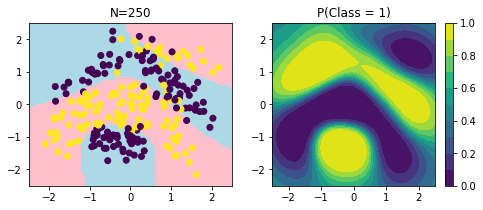

Outputscale:  Parameter containing:
tensor([0.3036, 0.2598], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[-0.1617]],

        [[-0.1715]]], requires_grad=True)
Step:  275 Train Loss:  tensor(4.2625, grad_fn=<NegBackward>)


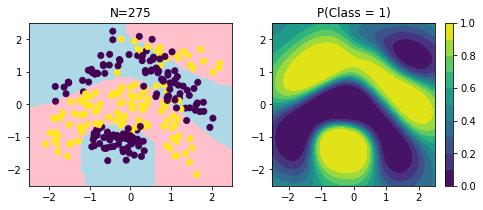

Outputscale:  Parameter containing:
tensor([0.3278, 0.2817], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[-0.1850]],

        [[-0.2008]]], requires_grad=True)
Step:  300 Train Loss:  tensor(4.1960, grad_fn=<NegBackward>)


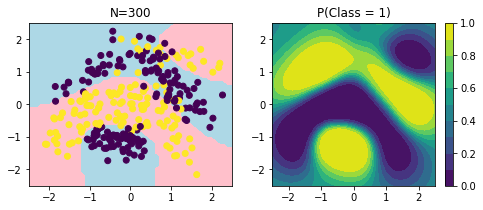

Outputscale:  Parameter containing:
tensor([0.3511, 0.3029], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[-0.2171]],

        [[-0.2430]]], requires_grad=True)
Step:  325 Train Loss:  tensor(4.0649, grad_fn=<NegBackward>)


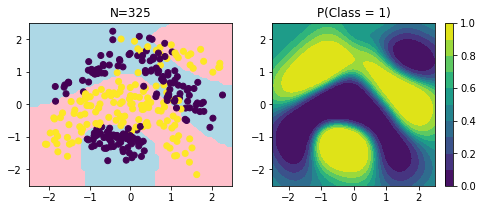

Outputscale:  Parameter containing:
tensor([0.3749, 0.3237], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[-0.2502]],

        [[-0.2886]]], requires_grad=True)
Step:  350 Train Loss:  tensor(4.0228, grad_fn=<NegBackward>)


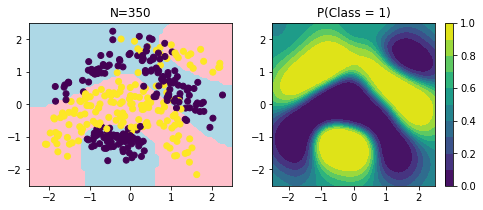

Outputscale:  Parameter containing:
tensor([0.3982, 0.3440], requires_grad=True)
Lengthscale:  Parameter containing:
tensor([[[-0.2812]],

        [[-0.3335]]], requires_grad=True)
Step:  375 Train Loss:  tensor(3.9859, grad_fn=<NegBackward>)


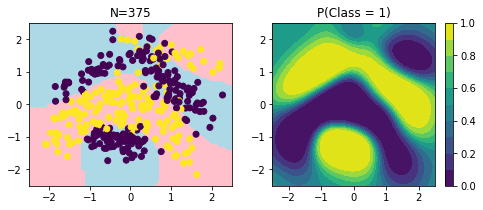

In [11]:
timing_list = []
for i in range(5, train_x.shape[0]):
    model.zero_grad()
    mll = BatchedWoodburyMarginalLogLikelihood(model.likelihood, model)

    start = time.time()
    with gpytorch.settings.skip_logdet_forward(True):
        loss = -mll(model(train_x[:i]), transformed_targets[:i]).sum()
    
    loss.backward()
        
    # [print(name, p.grad) for name, p in model.named_parameters()]
    optimizer.step()    
    model.zero_grad()
    optimizer.zero_grad()

    fwd_time = time.time() - start

    start = time.time()
    with torch.no_grad():
        model.condition_on_observations(
            train_x[i].unsqueeze(0), 
            transformed_targets[i].unsqueeze(0), 
            sigma2_i[i].unsqueeze(0), 
            inplace=True
        )
    fantasy_time = time.time() - start
    
    if i % 25 == 0:
        print('Outputscale: ', model.covar_module.base_kernel.raw_outputscale)
        print('Lengthscale: ', model.covar_module.base_kernel.base_kernel.raw_lengthscale)
        
        print('Step: ', i, 'Train Loss: ', loss)
        
        start = time.time()
        model.eval()
        with gpytorch.settings.detach_test_caches():
            pred_dist = model(pred_x)
        make_plot(pred_dist, i)
        plotting_time = time.time() - start
        model.train()
    
    timing_list.append([fwd_time, fantasy_time])

Finally, let's look at the overhead time, which is promising but not constant.

In [12]:
timing_array = torch.tensor(timing_list)

Text(0.5, 1.0, 'Fantasy Time')

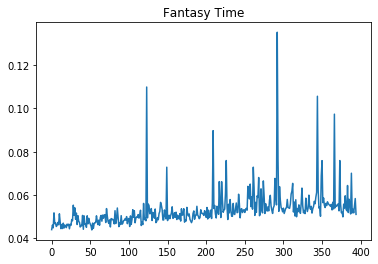

In [13]:
plt.plot(timing_array[:,1])
plt.title('Fantasy Time')

Text(0.5, 1.0, 'MLL Time')

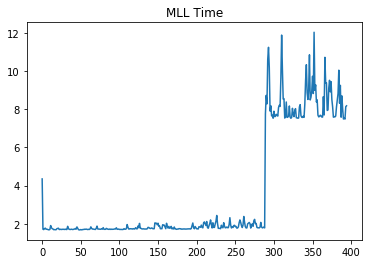

In [14]:
plt.plot(timing_array[:,0])
plt.title('MLL Time')

In [15]:
test_x = pd.read_csv("https://raw.githubusercontent.com/thangbui/streaming_sparse_gp/master/data/banana_test_x.txt",
                     header=None)
test_y = pd.read_csv("https://raw.githubusercontent.com/thangbui/streaming_sparse_gp/master/data/banana_test_y.txt",
                     header=None)

test_x = torch.tensor(test_x.values).float()

test_y = torch.tensor(test_y.values)#.float()
test_y[test_y < 0] = 0.
test_y = test_y.view(-1)

In [16]:
model.eval()
with gpytorch.settings.detach_test_caches():
    pred_dist = model(test_x)

In [23]:
(pred_dist.mean.argmax(0) == test_y).sum() / float(test_y.shape[0])

tensor(0.9024)